# **TCC - Recomendação de Cosméticos para Tratamento de Pele**
## Desenvolvido por: Lucas Rafael Hara Motta
## Especialização em Inteligência Artificial e Machine Aprendizado de Máquina
## PUC - MG

Este algoritmo foi desenvolvido como parte do Trabalho de Conclusão do Curso de Inteligência Artificial e Aprendizado de Máquina da PUC-MG.  
O trabalho tem como objetivo criar um algoritmo de recomendação de produtos de skincare a partir da base de dados da Sephora Malásia.
Este notebook contempla a análise inicial e exploratória dos dados coletados e desenvolvimento do algoritmo.    
Todas as informações, produtos e imagens coletados foram obtidos do site [Sephora Malaysia](https://www.sephora.my/).  

# 1. Importação das Bibliotecas

In [1]:
# Bibliotecas para manipulação dos dados
import pandas as pd
import numpy as np
import re

# Bibliotecas para geração de gráficos
import plotly.express as px
import matplotlib.pyplot as plt

# Bibliotecas para criação do modelo
from sklearn.metrics.pairwise import cosine_similarity

# 2. Processamento/Tratamento dos Dados

In [2]:
# Leitura do banco de dados gerado
df = pd.read_csv("../02 Datasets obtidos/Products Info.csv", sep='|')
df.sample(2)

,Brand,Name,Rating,Price,Product URL,Image URL,Category,Skin Type,Skin Concerns,Formulation,Skincare By Age,Ingredients,Function,Finish,Product Type,Benefits,Hair Type,Hair Concerns,Coverage
579,ESTÉE LAUDER,Nutritious Super-Pomegranate Radiant Energy Mo...,4.0,RM334.00,https://www.sephora.my/products/estee-lauder-n...,https://image-optimizer-reg.production.sephora...,Moisturiser,"Combination, Dry, Normal, Oily, Sensitive","Dryness, Dullness, Firmness & Elasticity",Cream,"20s, 30s, 40s, 50+, Under 20",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,NUDESTIX,Nudeskin 3-Step Citrus Skin Renewal Skincare Set,3.7,RM117.00,https://www.sephora.my/products/nudestix-nudes...,https://image-optimizer-reg.production.sephora...,Cleanser And Exfoliator,"Combination, Dry, Normal, Oily, Sensitive","Dryness, Dullness","Cream, Gel, Peel","20s, 30s, 40s, 50+, Under 20",Gentle Hydra-Gel Cleanser: Ingredients/Ingrédi...,"Exfoliating, Face, Hydrate","Natural, Radiant",NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963 entries, 0 to 1962
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Brand            1963 non-null   object 
 1   Name             1963 non-null   object 
 2   Rating           1751 non-null   float64
 3   Price            1963 non-null   object 
 4   Product URL      1963 non-null   object 
 5   Image URL        1963 non-null   object 
 6   Category         1963 non-null   object 
 7   Skin Type        1867 non-null   object 
 8   Skin Concerns    1907 non-null   object 
 9   Formulation      1601 non-null   object 
 10  Skincare By Age  1938 non-null   object 
 11  Ingredients      1574 non-null   object 
 12  Function         684 non-null    object 
 13  Finish           52 non-null     object 
 14  Product Type     13 non-null     object 
 15  Benefits         112 non-null    object 
 16  Hair Type        2 non-null      object 
 17  Hair Concerns 

In [4]:
# Mostra valores não-nulos por coluna
fig = px.bar(df.aggregate('count'),
       title="Quantidade de valores não-nulos por coluna",
       labels={'value':'Qtd. de valores', 'index':'Coluna', 'variable':'Contagem'},
       width=1100,
       text_auto=True)

fig.update_layout(showlegend=False)
fig.show()

## Análise de dados relevantes

In [5]:
# Remoção das colunas não relevantes e/ou com mais de 90% dos valores faltantes
df.drop(df.columns[13:], axis=1, inplace=True)

## Colunas "Brand" e "Name"

In [6]:
# Junção das colunas Brand e Name em uma única coluna
df['Full Name'] = df['Brand'] + " | " + df['Name']

df.loc[:, ['Brand', 'Name', 'Full Name']].sample(2)

,Brand,Name,Full Name
1052,PIXI,Pearl Brightening Oil,PIXI | Pearl Brightening Oil
1607,BURT'S BEES,Skin Nourishment Eye Cream • 14g,BURT'S BEES | Skin Nourishment Eye Cream • 14g


## Coluna "Price"

In [7]:
# Conversão do preço do produto de Ringgit Malaio (RM) para Dólares Americanos (USD)
# Conversão utilizada de 06/04/2022, onde 1 USD equivale a 4,22 RM

def convert_price(price):
    # Exemplo de preço : 'RM1,450.00(20% OFF)'
    # Conversão para 'U$ 343.60'

    usd_to_rm = 4.22

    conv_price = price.replace(",", "")
    conv_price = conv_price.split("RM")[-1]
    conv_price = conv_price.split("(")[0]
    conv_price = float(conv_price)/(usd_to_rm)
    conv_price = f"U$ {conv_price:.2f}"

    return conv_price


df['Price'] = df['Price'].apply(lambda x: convert_price(x))

df.loc[:, ['Full Name', 'Price']].sample(2)

,Full Name,Price
1961,FENTY SKIN | Hydra Vizor Invisible Broad Spect...,U$ 39.10
985,FRESH | Sugar Tinted Lip Treatment Sunscreen S...,U$ 24.41


## Colunas do Campo "Description"

In [8]:
# Transforma os valores das colunas "Skin Type”, “Skin Concerns”,
# “Formulation”, “Skincare By Age” e “Function” em uma lista.
# Valores nulos serão substituídos por strings vazias ("")

description_cols = ['Skin Type', 'Skin Concerns',
                    'Formulation', 'Skincare By Age', 'Function']

for col in description_cols:
    df[col] = df[col].fillna("")
    df[col] = df[col].apply(lambda x: x.split(', '))

# Mostra valores obtidos
for col in description_cols:

    itens = []

    for value in df[col]:
        valids = [v for v in value if v not in itens]
        itens += valids

    itens.sort()

    print("Coluna: ", col)
    print(itens, '\n')


Coluna:  Skin Type
['', 'Combination', 'Dry', 'Normal', 'Oily', 'Sensitive'] 

Coluna:  Skin Concerns
['', 'Ageing', 'Blackheads', 'Blemishes', 'Dark Circles', 'Dryness', 'Dullness', 'Fine Lines & Wrinkles', 'Firmness & Elasticity', 'Oiliness', 'Pigmentation & Dark Spots', 'Puffiness', 'Uneven Skin Texture', 'Uneven Skin Tone', 'Visible Pores'] 

Coluna:  Formulation
['', 'Balm', 'Bar', 'Charcoal', 'Clay/Mud', 'Cream', 'Foam', 'Gel', 'Liquid', 'Loose Powder', 'Lotion', 'Mousse', 'Oil', 'Peel', 'Powder', 'Pressed Powder', 'Serum', 'Sheet', 'Spray', 'Stick', 'Wash-Off', 'Wipe'] 

Coluna:  Skincare By Age
['', '20s', '30s', '40s', '50+', 'Under 20'] 

Coluna:  Function
['', 'Body Sunscreen', 'Body Tanner', 'Cleansing', 'Colour Correct', 'Curl', 'Cuticle Care', 'Exfoliating', 'Eye', 'Face', 'Face Sunscreen', 'Fill Pores', 'Finishing', 'Hydrate', 'Lip', 'Long-wearing', 'Mattify', 'Minimise Fine Lines/Wrinkles', 'Moisturise', 'Neck', 'Nose', 'Overnight', 'Powder', 'Setting', 'Smoothen', 'Tre

## Coluna "Ingredients"

In [9]:
# Remoção dos produtos que não possuem ingredientes
df = df.dropna(subset=['Ingredients'])

Remoção dos kits de produtos e produtos com mais de um tipo na hora da compra

- Exemplo de produto individual:

        Nome: GinZing™ Refreshing Scrub Cleanser
        Ingredientes:
            Water, Cocamidopropyl Hydroxysultaine, Coco-Betaine, Sodium Lauroyl Oat Amino Acids, etc.
- Exemplo de produto em kit ou com mais de uma opção:

        Nome: Colorful Vitamin Face Mask
        Opções: Dragonfruit Vitamin Mask / Papaya Vitamin Mask
        Ingredientes:
            Dragonfruit Vitamin Mask
            Ingredients : Aqua (Water), Butylene Glycol, Glycerin, Aloe Barbadensis Leaf Juice, etc.

            Papaya Vitamin Mask
            Ingredients : Aqua (Water), Butylene Glycol, Glycerin, Polyglyceryl-10 Laurate, etc.

In [10]:
# Remoção dos kits de produtos e produtos com mais de um tipo na hora da compra
# Identificado pelo caractere ":" ou "：".

# Remove os produtos com ":" ou "：" no campo 'Ingredients'
df = df[df['Ingredients'].map(
    lambda x: (":" not in x) and ("：" not in x)
)]

# Troca os caracteres de separação por "," e coloca o texto em letras minúsculas
for char in [", "," ,", "、", "|", "•"]:
    df['Ingredients'] = df['Ingredients'].map(
        lambda x: x.replace(char, ",").lower()
    )

# Separa os ingredientes em uma lista
df['Ingredients'] = df['Ingredients'].map(lambda x: x.split(","))


In [11]:
# Mostra ingredientes obtidos
itens = []

for value in df['Ingredients']:
    valids = [v for v in value if v not in itens]
    itens += valids

itens.sort()
print(f"\n{len(itens)} ingredientes encontrados")
for item in itens:
    print(item)


4775 ingredientes encontrados

 acetyl glucosamine 
 acrylamide/sodium acryloyldimethyltaurate copolymer 
 acrylates/c10-30 alkyl acrylate crosspolymer 
 alcaligenes polysaccharides 
 algae extract 
 allyl meth-acrylates crosspolymer
 aloe barbadensis leaf water 
 alteromonas ferment extract 
 ascorbyl glucoside 
 behenyl alcohol 
 benzophenone-4 
 bht 
 bis-peg-18 methyl ether dimethyl silane
 butylene glycol 
 butyrospermum parkii (shea butter) 
 butyrospermum parkii (shea) butter
 caf-feine
 caffeine 
 camellia sinensis leaf extract 
 caprylyl glycol 
 carbomer 
 cetearyl alcohol 
 cetearyl glucoside 
 cetyl alcohol 
 chlorphenesin 
 cholesterol 
 citric acid 
 cucumis sativus (cucumber) fruit extract 
 dehydroxanthan gum 
 dextrin palmitate 
 di-c12-15 alkyl fumarate 
 diglycerin 
 diisostearyl malate 
 dimethicone 
 dipotassium glycyrrhizate 
 disodium edta 
 ethylhexylglycerin 
 gentiana lutea (gentian) root extract 
 glycerin 
 glyceryl polymethacry_ate
 glyceryl stearate 
 gly

In [12]:
# Remoção de ingredientes separados por espaço ou outro caractere não convecional
# Método: remover produtos com o primeiro ingrediente com mais de 100 caracteres
df = df[df['Ingredients'].map(lambda x: len(x[0]) < 100)]

# Remoção dos textos entre parênteses e espaços que sucedem ou antecedem o conteúdo
# (Utilização de um loop para remover parênteses aninhados)
for _ in range(5):
    df['Ingredients'] = df['Ingredients'].map(
        lambda x: [re.sub('[(][^()]*[)]', '', word).strip() for word in x]
    )

# Remoção de caracteres que não são alfanuméricos
df['Ingredients'] = df['Ingredients'].map(
    lambda x: [re.sub(r'\W+', ' ', word).strip() for word in x]
)

Inconsistências com o ingrediente "água"
- Água é descrita de várias formas:

        'aqua eau'
        'aqua eau water'
        'aqua water'
        'aqua water eau'

In [13]:
# Reduz o ingrediente "água" escrito com outros termos e/ou repetido para "water"
def replace_water(ingredients_list):

    new_list = []
    for ingredient in ingredients_list:
        for code in ["eau", "aqua"]:
            ingredient = ingredient.replace(code, "water")
            ingredient = " ".join(dict.fromkeys(ingredient.split()))
        new_list.append(ingredient)

    return new_list


df['Ingredients'] = df['Ingredients'].map(replace_water)


        
Produtos com espaço inserido erroneamente:

        'astrocar yum murumuru seed butter'
        'astrocaryum murumuru seed butter'

In [14]:
# Remove os espaços dos ingredientes
df['Ingredients'] = df['Ingredients'].map(
    lambda x: [item.replace(" ", "") for item in x]
)

In [15]:
# Mostra ingredientes obtidos
itens = []

for value in df['Ingredients']:
    valids = [v for v in value if v not in itens]
    itens += valids

itens.sort()
print(f"\n{len(itens)} ingredientes encontrados")
for item in itens:
    print(item)


3606 ingredientes encontrados

000ppm
1
100bodysafesilicone
100coldpressedblueberryseedoil
100plantderivedsqualane
100unrefinedsclerocrayabirreakerneloil
10hydroxydecanoicacid
12heanediol
15713water
15885water
16024water
1methylhydantoin2imide
1octen3ylacetatefromessentialoils
2
20
20exfoliatingcomplex
2butanediol15dimethylether
2hexanediol
2hexanediolcaprylyl
2oethylascorbicacid
2phenoxyethanol
30ethylascorbicacid
3butanediol
3glycerylascorbate
3hexenol
3oethylascorbicacid
3propanetriol
4isobutylresorcinol
4tbutylcyclohexanol
4terpineol
77491
77499
abacaleaf
abiessibiricaoil
acaciadecurrensflowercera
acaciadecurrensflowerwax
acaciadecurrensjojobasunflowerseedwaxpolyglyceral3esters
acaciasenegal
acaciasenegalgum
acaciaseyalgum
acaciaseyalgumextract
acaciavictoriaeseedextract
acanthopanaxsenticosusrootextract
acersaccharumextract
acersaccharumsapextract
acetamidoethoxyethanol
aceticacid
acetone
acetum
acetyl
acetylatedglycolstearate
acetylcarnitinehcl
acetylcysteine
acetyldipeptide1cet

## Análise de Dados Ausentes

In [16]:
# Mostra valores não-nulos por coluna
fig = px.bar(df.aggregate('count'),
       title="Quantidade de valores não-nulos por coluna",
       labels={'value':'Qtd. de valores', 'index':'Coluna', 'variable':'Contagem'},
       width=1100,
       text_auto=True)

fig.update_layout(showlegend=False)
fig.show()

In [17]:
# Substituição dos valores nulos de classificação por "Sem Classificação"
df['Rating'] = df['Rating'].fillna("Sem Classificação")

## Criação da Matriz Binária (One-hot-encoding)

In [18]:
# Processo de one-hot-enconding

# Define as colunas que serão explodidas
exploding_cols = ['Category', 'Skin Type', 'Skin Concerns', 'Formulation', 'Skincare By Age', 'Ingredients', 'Function']

# Reseta os índices do dataframe original e cria o dataframe explodido (df_ohe)
df = df.reset_index(drop=True)
df_ohe = df.copy()

# Explosão da matriz
for col in exploding_cols:
    expld_df = df_ohe.explode(col)[col]
    expld_df = expld_df.apply(lambda x: None if x=='' else x)
    expld_df = pd.get_dummies(expld_df, columns=[col], prefix="".join([text[:4] for text in col.split(' ')]))
    pvt_table = expld_df.pivot_table(index=expld_df.index, aggfunc=sum)
    df_ohe = pd.concat([df_ohe, pvt_table], axis=1).drop(col, axis=1)

df_ohe.sample(1)

,Brand,Name,Rating,Price,Product URL,Image URL,Full Name,Cate_Cleanser And Exfoliator,Cate_Masks And Treatments,Cate_Moisturiser,...,Func_Long-wearing,Func_Mattify,Func_Minimise Fine Lines/Wrinkles,Func_Moisturise,Func_Neck,Func_Nose,Func_Overnight,Func_Powder,Func_Smoothen,Func_Treatment
1083,WISHFUL,Thirst Trap Cocoon Mask • 35g,4.0,U$ 10.66,https://www.sephora.my/products/wishful-thirst...,https://image-optimizer-reg.production.sephora...,WISHFUL | Thirst Trap Cocoon Mask • 35g,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1134 entries, 0 to 1133
Columns: 3670 entries, Brand to Func_Treatment
dtypes: object(7), uint8(3663)
memory usage: 4.0+ MB


## Criação da Matriz de Similaridade

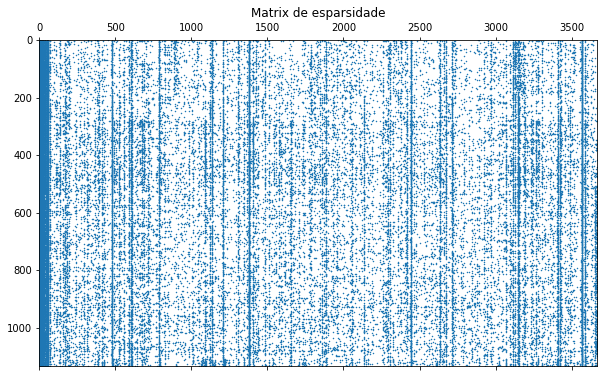

In [20]:
# Análise da esparsidade da matriz
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.spy(df_ohe.applymap(bool), markersize=0.5)
ax.set_aspect('auto')
plt.title("Matrix de esparsidade")
plt.show()

In [21]:
# Criação da matriz de similaridade (sim_matrix)
sim_matrix = cosine_similarity(df_ohe[df_ohe.columns[7:]])

print(f"Matriz no formato {sim_matrix.shape[0]} x {sim_matrix.shape[1]}.")

Matriz no formato 1134 x 1134.


## Exemplo de recomendação

In [22]:
# Seleção de um ID aleatório para teste de recomendação
id_item_procura = 759
df.iloc[id_item_procura]

Brand                                                     LAB SERIES
Name                                 Daily Rescue Energizing Essence
Rating                                             Sem Classificação
Price                                                       U$ 49.76
Product URL        https://www.sephora.my/products/lab-series-dai...
Image URL          https://image-optimizer-reg.production.sephora...
Category                                        Masks And Treatments
Skin Type                           [Combination, Dry, Normal, Oily]
Skin Concerns      [Ageing, Dryness, Dullness, Fine Lines & Wrink...
Formulation                                                       []
Skincare By Age                       [20s, 30s, 40s, 50+, Under 20]
Ingredients        [water, alcoholdenat, butyleneglycol, polysorb...
Function                                                          []
Full Name               LAB SERIES | Daily Rescue Energizing Essence
Name: 759, dtype: object

In [23]:
# Criação do algoritmo de busca dos produtos similares
def busca_similares(id_produto, sim_matrix):

    # Encontra os valores similares do produto indicado, colocando em ordem decrescente
    similar_list = list(enumerate(sim_matrix[id_produto]))
    sorted_similar_list = sorted(similar_list, key=lambda x: x[1], reverse=True)

    # Seleciona os 5 produtos mais similares (além do próprio produto)
    top_5 = sorted_similar_list[0:6]

    # Retorna a lista com os índices e valores de similaridade dos 5 produtos mais semelhantes
    top_5_idx, top_5_values = zip(*top_5)

    # Cria um dataframe com os 5 produtos mais semelhantes, baseado no dataframe original
    df_top_5 = df.iloc[list(top_5_idx)].copy()
    df_top_5['Similarity'] = [round(x, 2) for x in top_5_values]

    return df_top_5

df_top_5 = busca_similares(id_item_procura, sim_matrix)

df_top_5

,Brand,Name,Rating,Price,Product URL,Image URL,Category,Skin Type,Skin Concerns,Formulation,Skincare By Age,Ingredients,Function,Full Name,Similarity
759,LAB SERIES,Daily Rescue Energizing Essence,Sem Classificação,U$ 49.76,https://www.sephora.my/products/lab-series-dai...,https://image-optimizer-reg.production.sephora...,Masks And Treatments,"[Combination, Dry, Normal, Oily]","[Ageing, Dryness, Dullness, Fine Lines & Wrink...",[],"[20s, 30s, 40s, 50+, Under 20]","[water, alcoholdenat, butyleneglycol, polysorb...",[],LAB SERIES | Daily Rescue Energizing Essence,1.00
1032,LAB SERIES,Solid Water Essence,5.0,U$ 45.02,https://www.sephora.my/products/lab-series-sol...,https://image-optimizer-reg.production.sephora...,Masks And Treatments,"[Combination, Dry, Normal, Oily]","[Dryness, Dullness]",[Gel],"[20s, 30s, 40s, 50+, Under 20]","[water, alcoholdenat, butyleneglycol, polysorb...",[],LAB SERIES | Solid Water Essence,0.96
456,LAB SERIES,Pro LS All-In-One Hydrating Gel,Sem Classificação,U$ 29.62,https://www.sephora.my/products/lab-series-pro...,https://image-optimizer-reg.production.sephora...,Moisturiser,"[Combination, Dry, Normal, Oily]",[Dryness],[Gel],"[20s, 30s, 40s, 50+, Under 20]","[water, butyleneglycol, alcoholdenat, ammonium...",[],LAB SERIES | Pro LS All-In-One Hydrating Gel,0.63
579,LAB SERIES,Daily Rescue Repair Serum,Sem Classificação,U$ 69.91,https://www.sephora.my/products/lab-series-dai...,https://image-optimizer-reg.production.sephora...,Masks And Treatments,"[Combination, Dry, Normal, Oily]","[Ageing, Dryness, Fine Lines & Wrinkles, Uneve...",[Liquid],"[20s, 30s, 40s, 50+, Under 20]","[water, butyleneglycol, bispeg18methyletherdim...",[],LAB SERIES | Daily Rescue Repair Serum,0.62
581,ESTÉE LAUDER,Perfectionist Pro Intense Brightening Essence ...,5.0,U$ 125.83,https://www.sephora.my/products/estee-lauder-p...,https://image-optimizer-reg.production.sephora...,Masks And Treatments,"[Combination, Dry, Normal, Oily]","[Dryness, Dullness, Fine Lines & Wrinkles, Pig...","[Liquid, Lotion]","[20s, 30s, 40s, 50+, Under 20]","[water, peg8, butyleneglycol, ascorbylglucosid...",[],ESTÉE LAUDER | Perfectionist Pro Intense Brigh...,0.60
310,LAB SERIES,Daily Rescue Energizing Face Lotion,Sem Classificação,U$ 50.95,https://www.sephora.my/products/lab-series-dai...,https://image-optimizer-reg.production.sephora...,Moisturiser,"[Combination, Dry, Normal, Oily]","[Ageing, Dryness, Dullness, Fine Lines & Wrink...",[Lotion],"[20s, 30s, 40s, 50+, Under 20]","[water, niacinamide, octyldodecanol, glycerin,...",[],LAB SERIES | Daily Rescue Energizing Face Lotion,0.58


In [24]:
# Mostra versão resumida do df_top_5 (sem as colunas "Brand", "Name", "Product URL" e "Image URL")
df_resumed = pd.DataFrame()
df_resumed['Full Name'] = df_top_5['Full Name']
for col in df_top_5.drop('Full Name', axis=1):
    df_resumed[col] = df_top_5[col]

df_resumed.drop(["Brand", "Name", "Product URL", "Image URL"], axis=1, inplace=True)

df_resumed

,Full Name,Rating,Price,Category,Skin Type,Skin Concerns,Formulation,Skincare By Age,Ingredients,Function,Similarity
759,LAB SERIES | Daily Rescue Energizing Essence,Sem Classificação,U$ 49.76,Masks And Treatments,"[Combination, Dry, Normal, Oily]","[Ageing, Dryness, Dullness, Fine Lines & Wrink...",[],"[20s, 30s, 40s, 50+, Under 20]","[water, alcoholdenat, butyleneglycol, polysorb...",[],1.00
1032,LAB SERIES | Solid Water Essence,5.0,U$ 45.02,Masks And Treatments,"[Combination, Dry, Normal, Oily]","[Dryness, Dullness]",[Gel],"[20s, 30s, 40s, 50+, Under 20]","[water, alcoholdenat, butyleneglycol, polysorb...",[],0.96
456,LAB SERIES | Pro LS All-In-One Hydrating Gel,Sem Classificação,U$ 29.62,Moisturiser,"[Combination, Dry, Normal, Oily]",[Dryness],[Gel],"[20s, 30s, 40s, 50+, Under 20]","[water, butyleneglycol, alcoholdenat, ammonium...",[],0.63
579,LAB SERIES | Daily Rescue Repair Serum,Sem Classificação,U$ 69.91,Masks And Treatments,"[Combination, Dry, Normal, Oily]","[Ageing, Dryness, Fine Lines & Wrinkles, Uneve...",[Liquid],"[20s, 30s, 40s, 50+, Under 20]","[water, butyleneglycol, bispeg18methyletherdim...",[],0.62
581,ESTÉE LAUDER | Perfectionist Pro Intense Brigh...,5.0,U$ 125.83,Masks And Treatments,"[Combination, Dry, Normal, Oily]","[Dryness, Dullness, Fine Lines & Wrinkles, Pig...","[Liquid, Lotion]","[20s, 30s, 40s, 50+, Under 20]","[water, peg8, butyleneglycol, ascorbylglucosid...",[],0.60
310,LAB SERIES | Daily Rescue Energizing Face Lotion,Sem Classificação,U$ 50.95,Moisturiser,"[Combination, Dry, Normal, Oily]","[Ageing, Dryness, Dullness, Fine Lines & Wrink...",[Lotion],"[20s, 30s, 40s, 50+, Under 20]","[water, niacinamide, octyldodecanol, glycerin,...",[],0.58


## Armazenamento dos dados

In [25]:
# Armazena o dataframe final e a matriz de similaridade localmente
np.save("Similarity Matrix.npy", sim_matrix)
df.to_csv("Exploded Dataframe.csv", index=False)